## Data collection and processing of the GBR

In [42]:
# Geopandas uses Fiona for reading files which 
# in turn uses GDAL (for data transformation)

import gdal
import pandas as pd
import numpy as np
import geopandas as gpd
from io import StringIO
from shapely.geometry import Point
import osr
import matplotlib.pyplot as plt
import pandas as pd
#import esda
from scipy.spatial import cKDTree
import seaborn as sns
import os
import sys
sys.path.insert(0, os.path.abspath(''))
plt.style.use('ggplot') # use ggplot style

import data_processing_helper as dp
import practical_functions as pf
#import fiona // you can read directly from geopandas
import requests
import xarray as xr
import pygrib
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import netCDF4 as nc
import requests as rq

## Loading the Shapefiles for the Pacific

In [43]:
gdf_AUS = gpd.read_file('../Data/Reefs/shp_GBR/Reefs_GBR.shp')
gdf_IND = gpd.read_file('../Data/Reefs/shp_indonesia/indonesia.shp')
gdf_TLS = gpd.read_file('../Data/Reefs/shp_timorleste/timorleste.shp')
gdf_SLB = gpd.read_file('../Data/Reefs/shp_solomon/solomon.shp')

gdf_PAC = gpd.GeoDataFrame(pd.concat([gdf_AUS, gdf_IND, gdf_TLS, gdf_SLB]))

<AxesSubplot:>

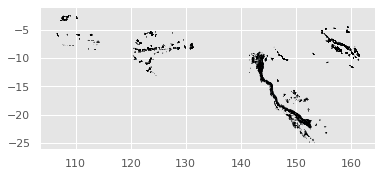

In [44]:
gdf_PAC.plot(edgecolor = "blacK")

## Loading the Survey folder
It contains the coordinates of the Survey and the percentage of algae, corals, soft_corals or other_invertebrates


In [49]:
Survey_global = pd.read_csv("../Data/Reefs/seaviewsurvey_surveys.csv")
Survey_global.head()

,surveyid,transectid,surveydate,ocean,country,folder_name,lat_start,lng_start,lat_end,lng_end,pr_hard_coral,pr_algae,pr_soft_coral,pr_oth_invert,pr_other
0,10001,10001,20120916,PAC,AUS,PAC_AUS_10001_201209,-16.189023,145.898104,-16.191761,145.894088,0.1856,0.3724,0.2710,0.0010,0.1700
1,10002,10002,20120917,PAC,AUS,PAC_AUS_10002_201209,-16.189303,145.898254,-16.175947,145.889736,0.1364,0.4766,0.3079,0.0020,0.0771
2,10003,10003,20120918,PAC,AUS,PAC_AUS_10003_201209,-16.175768,145.891676,-16.181218,145.888904,0.2475,0.5653,0.0747,0.0207,0.0917
3,10004,10004,20120920,PAC,AUS,PAC_AUS_10004_201209,-16.536645,147.806796,-16.524287,147.843325,0.1242,0.5706,0.0279,0.0023,0.2748
4,10005,10005,20120920,PAC,AUS,PAC_AUS_10005_201209,-16.529216,147.802582,-16.521689,147.836180,0.0781,0.7894,0.0096,0.0029,0.1201


In [50]:
Survey = Survey_global[(Survey_global["country"] == "AUS") | (Survey_global["country"] == "IDN") | (Survey_global["country"] == "TLS")| (Survey_global["country"] == "SLB")]
print("We now have a total of :",Survey.shape[0], " Surveys")
Survey.head()

We now have a total of : 421  Surveys


,surveyid,transectid,surveydate,ocean,country,folder_name,lat_start,lng_start,lat_end,lng_end,pr_hard_coral,pr_algae,pr_soft_coral,pr_oth_invert,pr_other
0,10001,10001,20120916,PAC,AUS,PAC_AUS_10001_201209,-16.189023,145.898104,-16.191761,145.894088,0.1856,0.3724,0.2710,0.0010,0.1700
1,10002,10002,20120917,PAC,AUS,PAC_AUS_10002_201209,-16.189303,145.898254,-16.175947,145.889736,0.1364,0.4766,0.3079,0.0020,0.0771
2,10003,10003,20120918,PAC,AUS,PAC_AUS_10003_201209,-16.175768,145.891676,-16.181218,145.888904,0.2475,0.5653,0.0747,0.0207,0.0917
3,10004,10004,20120920,PAC,AUS,PAC_AUS_10004_201209,-16.536645,147.806796,-16.524287,147.843325,0.1242,0.5706,0.0279,0.0023,0.2748
4,10005,10005,20120920,PAC,AUS,PAC_AUS_10005_201209,-16.529216,147.802582,-16.521689,147.836180,0.0781,0.7894,0.0096,0.0029,0.1201


In [51]:
Survey['surveydate'] = pd.to_datetime(Survey['surveydate'], format='%Y%m%d')
Survey.head()

,surveyid,transectid,surveydate,ocean,country,folder_name,lat_start,lng_start,lat_end,lng_end,pr_hard_coral,pr_algae,pr_soft_coral,pr_oth_invert,pr_other
0,10001,10001,2012-09-16,PAC,AUS,PAC_AUS_10001_201209,-16.189023,145.898104,-16.191761,145.894088,0.1856,0.3724,0.2710,0.0010,0.1700
1,10002,10002,2012-09-17,PAC,AUS,PAC_AUS_10002_201209,-16.189303,145.898254,-16.175947,145.889736,0.1364,0.4766,0.3079,0.0020,0.0771
2,10003,10003,2012-09-18,PAC,AUS,PAC_AUS_10003_201209,-16.175768,145.891676,-16.181218,145.888904,0.2475,0.5653,0.0747,0.0207,0.0917
3,10004,10004,2012-09-20,PAC,AUS,PAC_AUS_10004_201209,-16.536645,147.806796,-16.524287,147.843325,0.1242,0.5706,0.0279,0.0023,0.2748
4,10005,10005,2012-09-20,PAC,AUS,PAC_AUS_10005_201209,-16.529216,147.802582,-16.521689,147.836180,0.0781,0.7894,0.0096,0.0029,0.1201


In [52]:
gSurvey = gpd.GeoDataFrame(Survey, geometry = gpd.points_from_xy(Survey.lng_start, Survey.lat_start))
gSurvey["country"].value_counts()

AUS    261
IDN    114
TLS     26
SLB     20
Name: country, dtype: int64

In [53]:
gSurvey

,surveyid,transectid,surveydate,ocean,country,folder_name,lat_start,lng_start,lat_end,lng_end,pr_hard_coral,pr_algae,pr_soft_coral,pr_oth_invert,pr_other,geometry
0,10001,10001,2012-09-16,PAC,AUS,PAC_AUS_10001_201209,-16.189023,145.898104,-16.191761,145.894088,0.1856,0.3724,0.2710,0.0010,0.1700,POINT (145.89810 -16.18902)
1,10002,10002,2012-09-17,PAC,AUS,PAC_AUS_10002_201209,-16.189303,145.898254,-16.175947,145.889736,0.1364,0.4766,0.3079,0.0020,0.0771,POINT (145.89825 -16.18930)
2,10003,10003,2012-09-18,PAC,AUS,PAC_AUS_10003_201209,-16.175768,145.891676,-16.181218,145.888904,0.2475,0.5653,0.0747,0.0207,0.0917,POINT (145.89168 -16.17577)
3,10004,10004,2012-09-20,PAC,AUS,PAC_AUS_10004_201209,-16.536645,147.806796,-16.524287,147.843325,0.1242,0.5706,0.0279,0.0023,0.2748,POINT (147.80680 -16.53665)
4,10005,10005,2012-09-20,PAC,AUS,PAC_AUS_10005_201209,-16.529216,147.802582,-16.521689,147.836180,0.0781,0.7894,0.0096,0.0029,0.1201,POINT (147.80258 -16.52922)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
855,64043,32023,2018-06-17,PAC,IDN,PAC_IDN_64043_201806,1.671353,125.133216,1.683241,125.140024,0.1148,0.4541,0.0658,0.0307,0.3346,POINT (125.13322 1.67135)
856,64044,32012,2018-06-17,PAC,IDN,PAC_IDN_64044_201806,1.734514,125.150193,1.744193,125.140225,0.0587,0.5438,0.0504,0.0512,0.2962,POINT (125.15019 1.73451)
857,64045,32010,2018-06-18,PAC,IDN,PAC_IDN_64045_201806,1.836848,125.146803,1.848762,125.137938,0.0373,0.6490,0.0072,0.0157,0.2908,POINT (125.14680 1.83685)
858,64046,32011,2018-06-18,PAC,IDN,PAC_IDN_64046_201806,1.773760,125.130850,1.752770,125.131721,0.0815,0.6142,0.0238,0.0328,0.2477,POINT (125.13085 1.77376)


In [54]:
# Keep only month and year
gSurvey['surveydate'] = gSurvey['surveydate'].dt.strftime('%Y-%m')

In [55]:
# Same content but only for Australia 
Survey_AUS = Survey_global[Survey_global['country'] == 'AUS']
Survey_AUS.head()

,surveyid,transectid,surveydate,ocean,country,folder_name,lat_start,lng_start,lat_end,lng_end,pr_hard_coral,pr_algae,pr_soft_coral,pr_oth_invert,pr_other
0,10001,10001,20120916,PAC,AUS,PAC_AUS_10001_201209,-16.189023,145.898104,-16.191761,145.894088,0.1856,0.3724,0.2710,0.0010,0.1700
1,10002,10002,20120917,PAC,AUS,PAC_AUS_10002_201209,-16.189303,145.898254,-16.175947,145.889736,0.1364,0.4766,0.3079,0.0020,0.0771
2,10003,10003,20120918,PAC,AUS,PAC_AUS_10003_201209,-16.175768,145.891676,-16.181218,145.888904,0.2475,0.5653,0.0747,0.0207,0.0917
3,10004,10004,20120920,PAC,AUS,PAC_AUS_10004_201209,-16.536645,147.806796,-16.524287,147.843325,0.1242,0.5706,0.0279,0.0023,0.2748
4,10005,10005,20120920,PAC,AUS,PAC_AUS_10005_201209,-16.529216,147.802582,-16.521689,147.836180,0.0781,0.7894,0.0096,0.0029,0.1201


In [56]:
shape_GBR = gpd.read_file("../Data/GBR_shapes_surveys/Reefs_GBR.shp")

#ax = shape_GBR.plot()
#ax.set_title("GBR shape file")


In [57]:
dbf = gpd.read_file("../Data/GBR_shapes_surveys/Reefs_GBR.dbf")

# dbf.geometry (geoseries)
dbf.head()

,id,geometry
0,R000029,"POLYGON ((141.56196 -9.53949, 141.55818 -9.539..."
1,R000030,"POLYGON ((141.58334 -9.59231, 141.57877 -9.592..."
2,R000031,"POLYGON ((141.57196 -9.62410, 141.57181 -9.624..."
3,R000046,"POLYGON ((141.54224 -10.37799, 141.54203 -10.3..."
4,R000089,"POLYGON ((141.57953 -12.54231, 141.57026 -12.5..."


In [58]:
proj4 = dp.esriprj2standards("../Data/GBR_shapes_surveys/Reefs_GBR.prj")


In [59]:
# Make geo data frame 
gSurvey_AUS = gpd.GeoDataFrame(Survey_AUS, geometry = gpd.points_from_xy(Survey_AUS.lng_start, Survey_AUS.lat_start))

## Loading the Degree Heating Week 

In [60]:
DHW = pd.read_csv("../Data/Environmental_data/DHW.csv")
DHW.head()

,id,1985.04,1985.05,1985.06,1985.07,1985.08,1985.09,1985.10,1985.11,1985.12,...,2020.03,2020.04,2020.05,2020.06,2020.07,2020.08,2020.09,2020.10,2020.11,2020.12
0,R000029,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.012667,0.190000,...,4.104839,2.217000,0.619032,0.000000,0.0,0.0,0.0,0.0,0.0,0.890000
1,R000030,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.012000,0.180000,...,5.163871,2.685000,0.753226,0.000000,0.0,0.0,0.0,0.0,0.0,0.997742
2,R000031,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.012000,0.180000,...,5.542581,2.736333,0.782581,0.000000,0.0,0.0,0.0,0.0,0.0,1.035161
3,R000046,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.093871,...,8.391613,3.843667,1.386774,0.005333,0.0,0.0,0.0,0.0,0.0,1.117419
4,R000089,0.063333,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.453226,...,2.349032,1.258333,0.559032,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000


In [61]:
DHW_temp = DHW.drop(columns = "id")

In [62]:
DHW_temp.columns = pd.to_datetime(DHW_temp.columns)
#DHW_temp.columns = DHW_temp.columns.strftime("%Y.%m")

In [63]:
DHW_temp.insert(0, "id", DHW["id"])
DHW = DHW_temp.copy()
# Adding the shape file to DHW
if("geometry" not in DHW.columns):
    DHW = DHW.merge(shape_GBR, on = "id")

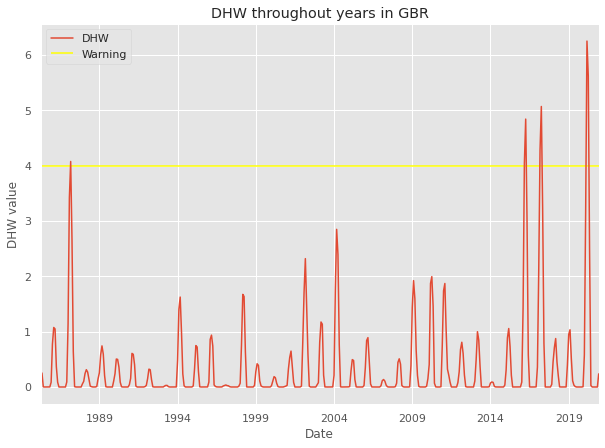

In [64]:
fig = DHW.mean(axis = 0).plot(figsize = (10,7), label = "DHW")
plt.title("DHW throughout years in GBR")
plt.ylabel("DHW value")
plt.xlabel("Date")
plt.hlines(4, 0,DHW.shape[0], color = "yellow", label ="Warning")
#plt.hlines(8, 0,DHW.shape[1], color = "yellow", label = "Alert 1")
#plt.hlines(4, 0,DHW.shape[1], color = "yellow", label = "Alert 2")
plt.legend()

We can see a tendency of increase in the last years. What is shocking is that, this is an average over a month, so in the last years, we are over the warning limit for coral bleaching

Text(0.5, 0, 'Date')

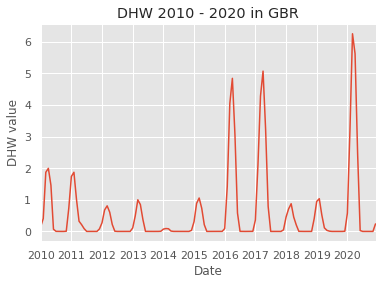

In [65]:
fig = DHW[DHW.columns[298:]].mean(axis = 0).plot()
plt.title("DHW 2010 - 2020 in GBR")
plt.ylabel("DHW value")
plt.xlabel("Date")

Let us now check the spatial distribution of the areas.


Text(0.5, 1.0, 'Mean DHW per region')

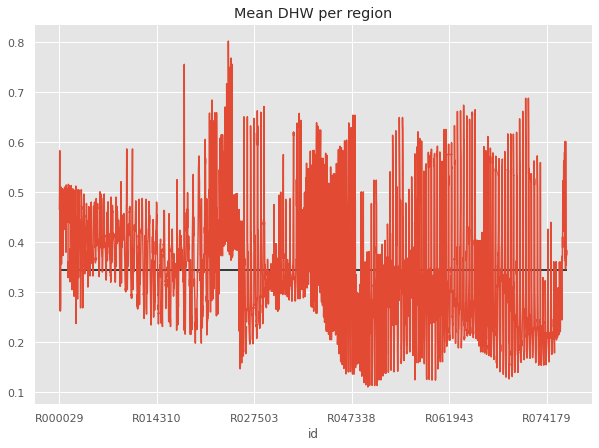

In [66]:
fig = DHW.set_index("id").mean(axis = 1).plot(figsize = (10,7))
plt.hlines(DHW.set_index("id").mean(axis = 1).mean(), 0,DHW.shape[0], color = "black")
plt.title("Mean DHW per region")

In [67]:
df = DHW.mean(axis = 0)[9:]
df = df.reset_index()

df.index = pd.to_datetime(df["index"], format = "%Y.%m.%d")
df.drop(columns = "index", inplace = True)
df.groupby(pd.Grouper(freq='m')).sum()
#DHW.mean(axis = 0)[9:].groupby((DHW.mean(axis = 0)[9:].index)//12).sum()

,0
index,
1986-01-31,0.776524
1986-02-28,1.075430
1986-03-31,1.049817
1986-04-30,0.367281
1986-05-31,0.086135
...,...
2020-08-31,0.000000
2020-09-30,0.000000
2020-10-31,0.000000


Text(0, 0.5, 'DHW')

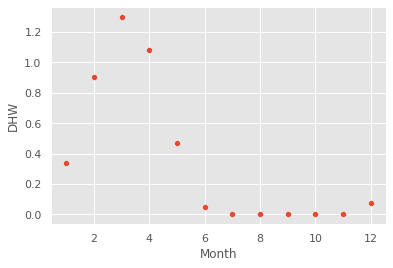

In [68]:


DHW_month = df.groupby(by=[df.index.month]).mean()
DHW_month.rename(columns = {0:"value"}, inplace = True)
ax = sns.scatterplot(x = DHW_month.index, y = DHW_month["value"])
ax.set_xlabel("Month")
ax.set_ylabel("DHW")

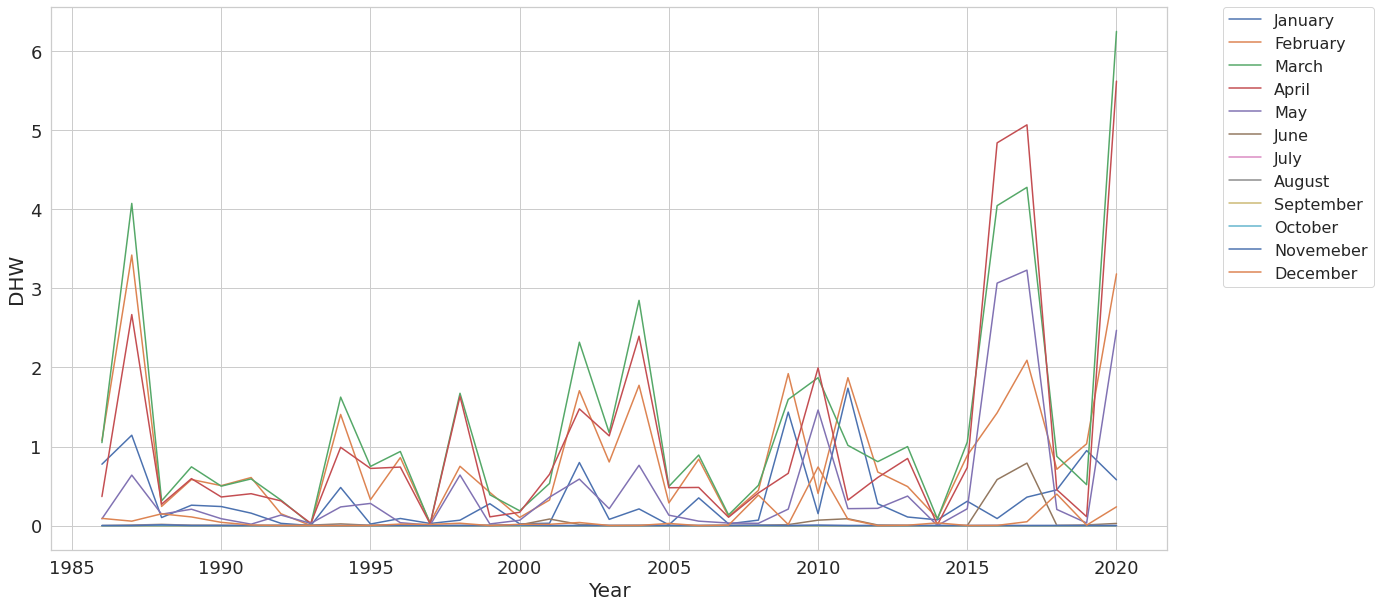

In [24]:
df_w= df.groupby(by=[df.index.month, df.index.year]).mean()


plt.figure(figsize = (20,10))
fig = sns.lineplot(x = df_w.loc[1].index, y = df_w.loc[1][0],label = "January")
sns.lineplot(x = df_w.loc[2].index, y = df_w.loc[2][0],label = "February")
sns.lineplot(x = df_w.loc[3].index, y = df_w.loc[3][0],label = "March")
sns.lineplot(x = df_w.loc[4].index, y = df_w.loc[4][0],label = "April")
sns.lineplot(x = df_w.loc[5].index, y = df_w.loc[5][0],label = "May")
sns.lineplot(x = df_w.loc[6].index, y = df_w.loc[6][0],label = "June")
sns.lineplot(x = df_w.loc[7].index, y = df_w.loc[7][0],label = "July")
sns.lineplot(x = df_w.loc[8].index, y = df_w.loc[8][0],label = "August")
sns.lineplot(x = df_w.loc[9].index, y = df_w.loc[9][0],label = "September")
sns.lineplot(x = df_w.loc[10].index, y = df_w.loc[10][0],label = "October")
sns.lineplot(x = df_w.loc[11].index, y = df_w.loc[11][0],label = "Novemeber")
sns.lineplot(x = df_w.loc[12].index, y = df_w.loc[12][0],label = "December")
plt.ylabel("DHW", fontsize = 20)
plt.xlabel("Year", fontsize = 20)
fig.tick_params(labelsize=18)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize = 16)

### Look at how it changes with regions

In [69]:
red = pd.read_csv("../Data/Environmental_data/DHW.csv")
DHW_temp = red.drop(columns = "id")
DHW_temp.columns = pd.to_datetime(DHW_temp.columns)
#DHW_temp.columns = DHW_temp.columns.strftime("%Y.%m")



In [70]:
df_diff = DHW["id"].copy()
df_diff = pd.DataFrame(df_diff)
df_diff["jan_dif"] = red['2020.01'] - red['1986.01']
df_diff["feb_dif"] = red['2020.02'] - red['1986.02']
df_diff["march_dif"] = red['2020.03'] - red['1986.03']
df_diff["april_dif"] = red['2020.04'] - red['1986.04']
df_diff["may_dif"] = red['2020.05'] - red['1986.05']
df_diff["june_dif"] = red['2020.06'] - red['1986.06']
df_diff["july_dif"] = red['2020.07'] - red['1986.07']
df_diff["aug_dif"] = red['2020.08'] - red['1986.08']
df_diff["sep_dif"] = red['2020.09'] - red['1986.09']
df_diff["oct_dif"] = red['2020.10'] - red['1986.10']
df_diff["nov_dif"] = red['2020.11'] - red['1986.11']
df_diff["dec_dif"] = red['2020.12'] - red['1986.12']


Text(0.5, 0, 'Region')

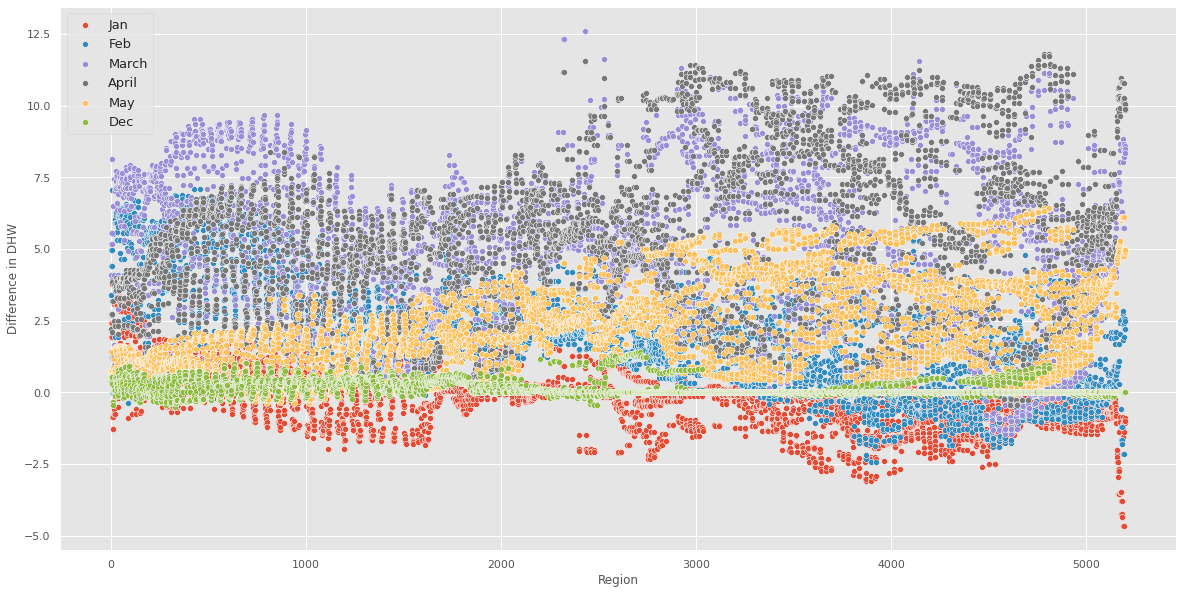

In [71]:
plt.figure(figsize = (20,10))
sns.scatterplot(x = df_diff.index, y = df_diff["jan_dif"], label = "Jan")
sns.scatterplot(x = df_diff.index, y = df_diff["feb_dif"], label = "Feb")
sns.scatterplot(x = df_diff.index, y = df_diff["march_dif"], label = "March")
sns.scatterplot(x = df_diff.index, y = df_diff["april_dif"], label = "April")
sns.scatterplot(x = df_diff.index, y = df_diff["may_dif"], label = "May")
sns.scatterplot(x = df_diff.index, y = df_diff["dec_dif"], label = "Dec")
plt.legend(fontsize = 13)
plt.ylabel("Difference in DHW")
plt.xlabel("Region")

In [72]:
DHW["id"] = DHW["id"].str.replace('R', "").astype(int)


In [73]:
DHW

,id,1985-04-01 00:00:00,1985-05-01 00:00:00,1985-06-01 00:00:00,1985-07-01 00:00:00,1985-08-01 00:00:00,1985-09-01 00:00:00,1985-10-01 00:00:00,1985-11-01 00:00:00,1985-12-01 00:00:00,...,2020-04-01 00:00:00,2020-05-01 00:00:00,2020-06-01 00:00:00,2020-07-01 00:00:00,2020-08-01 00:00:00,2020-09-01 00:00:00,2020-10-01 00:00:00,2020-11-01 00:00:00,2020-12-01 00:00:00,geometry
0,29,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.012667,0.190000,...,2.217000,0.619032,0.000000,0.0,0.0,0.0,0.0,0.0,0.890000,"POLYGON ((141.56196 -9.53949, 141.55818 -9.539..."
1,30,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.012000,0.180000,...,2.685000,0.753226,0.000000,0.0,0.0,0.0,0.0,0.0,0.997742,"POLYGON ((141.58334 -9.59231, 141.57877 -9.592..."
2,31,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.012000,0.180000,...,2.736333,0.782581,0.000000,0.0,0.0,0.0,0.0,0.0,1.035161,"POLYGON ((141.57196 -9.62410, 141.57181 -9.624..."
3,46,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.093871,...,3.843667,1.386774,0.005333,0.0,0.0,0.0,0.0,0.0,1.117419,"POLYGON ((141.54224 -10.37799, 141.54203 -10.3..."
4,89,0.063333,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.453226,...,1.258333,0.559032,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,"POLYGON ((141.57953 -12.54231, 141.57026 -12.5..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5197,95224,0.281667,0.116129,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,11.679667,5.038710,0.059667,0.0,0.0,0.0,0.0,0.0,0.000000,"POLYGON ((155.53334 -23.27021, 155.53334 -23.2..."
5198,95561,0.136333,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,11.723000,5.124516,0.061000,0.0,0.0,0.0,0.0,0.0,0.000000,"POLYGON ((155.62003 -23.19231, 155.60992 -23.1..."
5199,95562,0.134667,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,11.830333,5.112581,0.061667,0.0,0.0,0.0,0.0,0.0,0.000000,"POLYGON ((155.63086 -23.24231, 155.62435 -23.2..."
5200,95563,0.343667,0.108387,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,11.837333,5.070000,0.061000,0.0,0.0,0.0,0.0,0.0,0.000000,"POLYGON ((155.59379 -23.27082, 155.59362 -23.2..."


<AxesSubplot:>

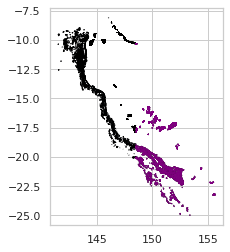

In [29]:
DHW_high = DHW.iloc[DHW.index > 3000]
DHW_high = pf.make_geo_frame(DHW_high)
ax =shape_GBR.plot(edgecolor='black')
DHW_high.plot(ax =ax, color = "black",edgecolor='purple')

## Loading the Surface Sea Temperature

In [30]:
SST = pd.read_csv("../Data/Environmental_data/SST.csv")
SST.head()

,id,1985.04,1985.05,1985.06,1985.07,1985.08,1985.09,1985.10,1985.11,1985.12,...,2020.03,2020.04,2020.05,2020.06,2020.07,2020.08,2020.09,2020.10,2020.11,2020.12
0,R000029,28.055000,27.038065,26.068000,24.721935,24.205161,25.359333,26.543548,28.950667,29.512258,...,29.788387,29.390667,27.720000,26.773667,25.894839,26.427419,26.416333,27.531613,29.082333,30.110323
1,R000030,28.042000,27.030323,26.094667,24.719355,24.217742,25.373333,26.549677,28.954667,29.518710,...,29.796129,29.383000,27.722258,26.770333,25.886129,26.409677,26.388000,27.500000,29.088667,30.130645
2,R000031,28.036000,27.030968,26.121333,24.716129,24.232903,25.390000,26.559355,28.955000,29.522903,...,29.800968,29.367333,27.728710,26.771000,25.879355,26.387419,26.359000,27.458387,29.088667,30.143226
3,R000046,28.152333,27.063871,26.075667,24.718387,24.319032,25.602333,26.435806,28.690000,29.453871,...,29.828065,29.215333,27.718710,26.629333,25.771290,26.204194,26.135333,27.179032,28.916333,30.065161
4,R000089,28.455667,27.833548,26.096333,24.127097,23.661613,25.460333,26.666452,28.509667,30.069032,...,30.051935,29.602667,27.690000,26.251667,25.471935,26.066452,26.550333,27.784516,29.379333,29.982581


In [31]:
SST_temp = SST.drop(columns = "id")
SST_temp.columns = pd.to_datetime(SST_temp.columns)
#DHW_temp.columns = DHW_temp.columns.strftime("%Y.%m")

In [32]:
SST_temp.insert(0, "id", SST["id"])
SST = SST_temp.copy()
# Adding the shape file to DHW
if("geometry" not in SST.columns):
    SST = SST.merge(shape_GBR, on = "id")

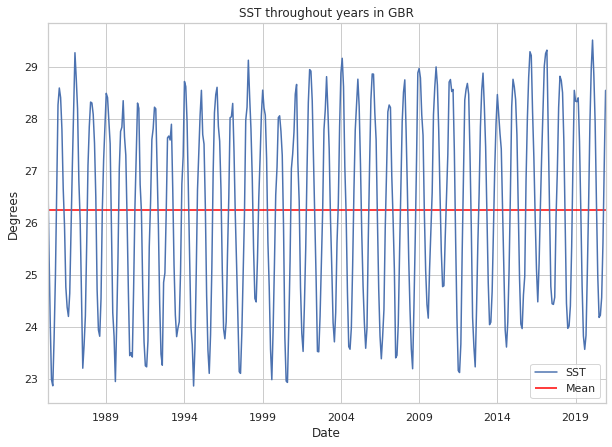

In [33]:
fig = SST.mean(axis = 0).plot(figsize = (10,7), label = "SST")
plt.title("SST throughout years in GBR")
plt.ylabel("Degrees")
plt.xlabel("Date")
plt.hlines(SST.mean(axis = 0).mean(), 0,SST.shape[0], color = "red", label ="Mean")

plt.legend()

Text(0.5, 0, 'Date')

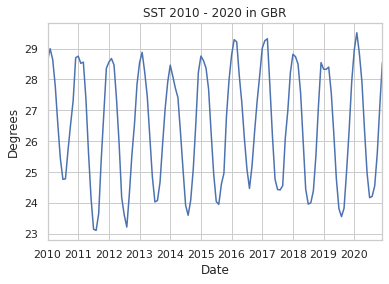

In [34]:
fig = SST[SST.columns[298:]].mean(axis = 0).plot()
plt.title("SST 2010 - 2020 in GBR")
plt.ylabel("Degrees")
plt.xlabel("Date")


Text(0.5, 1.0, 'Mean SST per region')

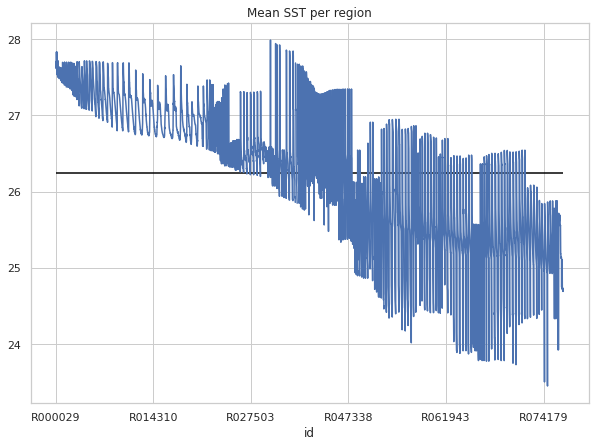

In [35]:

fig = SST.set_index("id").mean(axis = 1).plot(figsize = (10,7))
plt.hlines(SST.set_index("id").mean(axis = 1).mean(), 0,SST.shape[0], color = "black")
plt.title("Mean SST per region")

In [36]:
df = SST.mean(axis = 0)[9:]
df = df.reset_index()

df.index = pd.to_datetime(df["index"], format = "%Y.%m.%d")
df.drop(columns = "index", inplace = True)
df.groupby(pd.Grouper(freq='m')).sum()
#DHW.mean(axis = 0)[9:].groupby((DHW.mean(axis = 0)[9:].index)//12).sum()



,0
index,
1986-01-31,28.588323
1986-02-28,28.403749
1986-03-31,27.795631
1986-04-30,26.651975
1986-05-31,25.931427
...,...
2020-08-31,24.217831
2020-09-30,24.558049
2020-10-31,25.604790


Text(0, 0.5, 'Degree')

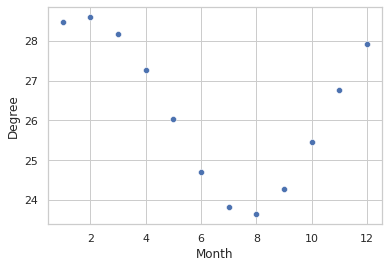

In [37]:
SST_month = df.groupby(by=[df.index.month]).mean()
SST_month.rename(columns = {0:"value"}, inplace = True)
ax = sns.scatterplot(x = SST_month.index, y = SST_month["value"])
ax.set_xlabel("Month")
ax.set_ylabel("Degree")

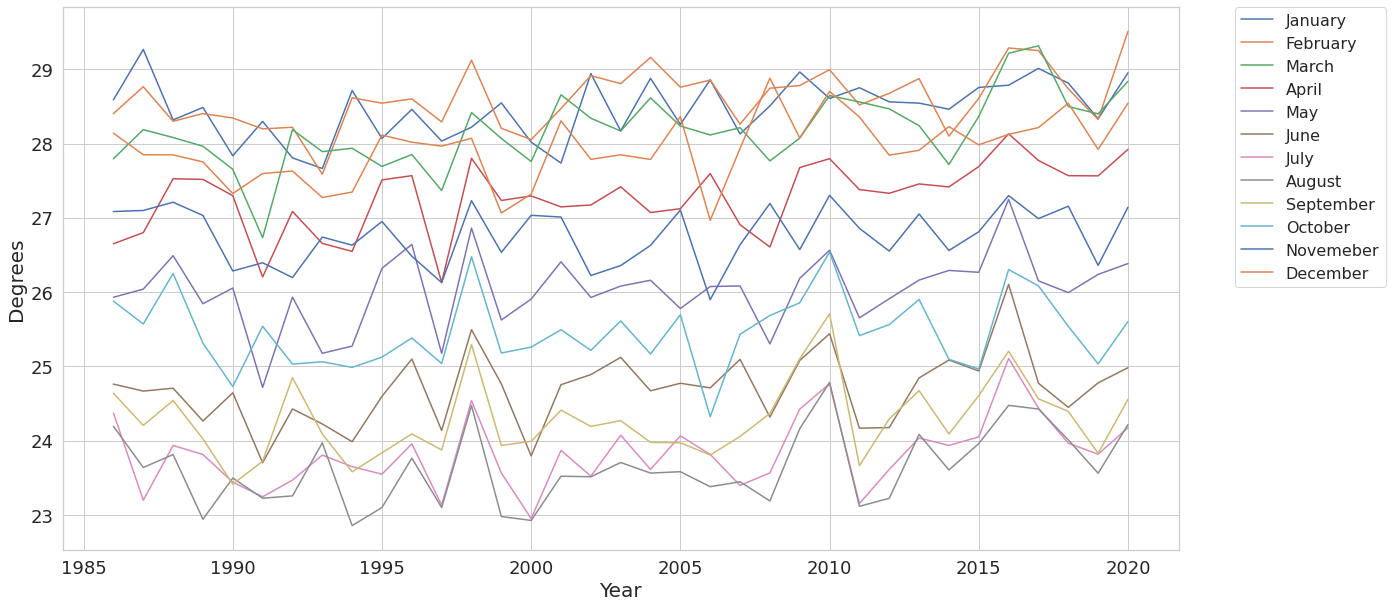

In [38]:
df_w= df.groupby(by=[df.index.month, df.index.year]).mean()


plt.figure(figsize = (20,10))
fig = sns.lineplot(x = df_w.loc[1].index, y = df_w.loc[1][0],label = "January")
sns.lineplot(x = df_w.loc[2].index, y = df_w.loc[2][0],label = "February")
sns.lineplot(x = df_w.loc[3].index, y = df_w.loc[3][0],label = "March")
sns.lineplot(x = df_w.loc[4].index, y = df_w.loc[4][0],label = "April")
sns.lineplot(x = df_w.loc[5].index, y = df_w.loc[5][0],label = "May")
sns.lineplot(x = df_w.loc[6].index, y = df_w.loc[6][0],label = "June")
sns.lineplot(x = df_w.loc[7].index, y = df_w.loc[7][0],label = "July")
sns.lineplot(x = df_w.loc[8].index, y = df_w.loc[8][0],label = "August")
sns.lineplot(x = df_w.loc[9].index, y = df_w.loc[9][0],label = "September")
sns.lineplot(x = df_w.loc[10].index, y = df_w.loc[10][0],label = "October")
sns.lineplot(x = df_w.loc[11].index, y = df_w.loc[11][0],label = "Novemeber")
sns.lineplot(x = df_w.loc[12].index, y = df_w.loc[12][0],label = "December")
plt.ylabel("Degrees", fontsize = 20)
plt.xlabel("Year", fontsize = 20)
fig.tick_params(labelsize=18)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize = 16)

In [39]:
red = pd.read_csv("../Data/Environmental_data/SST.csv")
SST_temp = red.drop(columns = "id")
SST_temp.columns = pd.to_datetime(SST_temp.columns)
#DHW_temp.columns = DHW_temp.columns.strftime("%Y.%m")
SST_temp.columns


df_diff = DHW["id"].copy()
df_diff = pd.DataFrame(df_diff)
df_diff["jan_dif"] = red['2020.01'] - red['1986.01']
df_diff["feb_dif"] = red['2020.02'] - red['1986.02']
df_diff["march_dif"] = red['2020.03'] - red['1986.03']
df_diff["april_dif"] = red['2020.04'] - red['1986.04']
df_diff["may_dif"] = red['2020.05'] - red['1986.05']
df_diff["june_dif"] = red['2020.06'] - red['1986.06']
df_diff["july_dif"] = red['2020.07'] - red['1986.07']
df_diff["aug_dif"] = red['2020.08'] - red['1986.08']
df_diff["sep_dif"] = red['2020.09'] - red['1986.09']
df_diff["oct_dif"] = red['2020.10'] - red['1986.10']
df_diff["nov_dif"] = red['2020.11'] - red['1986.11']
df_diff["dec_dif"] = red['2020.12'] - red['1986.12']


Text(0.5, 0, 'Region')

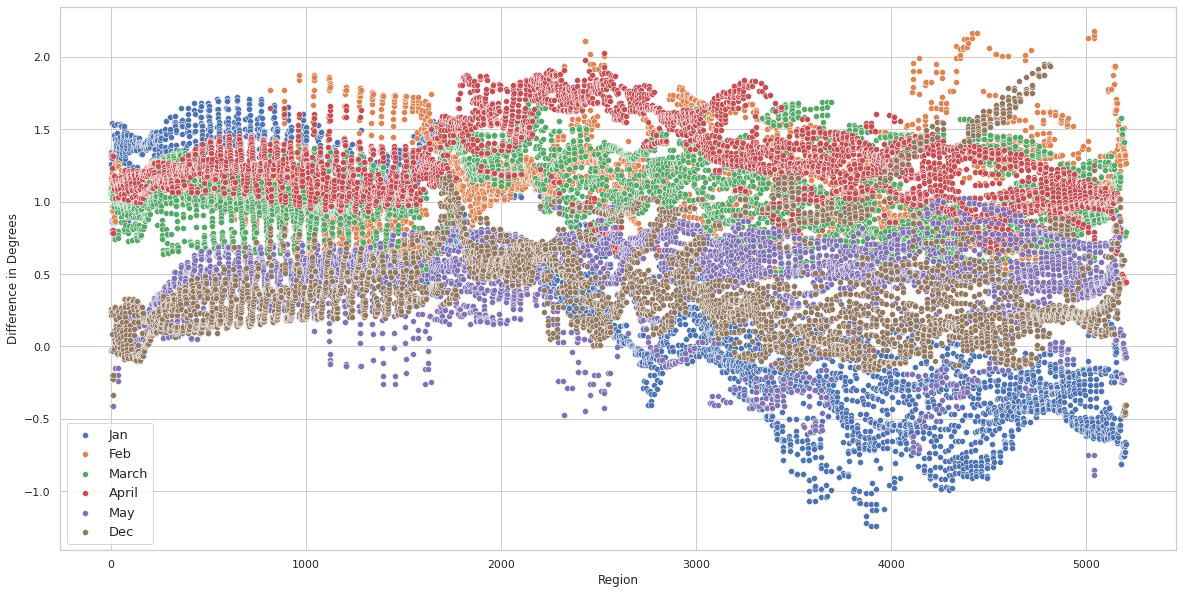

In [40]:
plt.figure(figsize = (20,10))
sns.scatterplot(x = df_diff.index, y = df_diff["jan_dif"], label = "Jan")
sns.scatterplot(x = df_diff.index, y = df_diff["feb_dif"], label = "Feb")
sns.scatterplot(x = df_diff.index, y = df_diff["march_dif"], label = "March")
sns.scatterplot(x = df_diff.index, y = df_diff["april_dif"], label = "April")
sns.scatterplot(x = df_diff.index, y = df_diff["may_dif"], label = "May")
sns.scatterplot(x = df_diff.index, y = df_diff["dec_dif"], label = "Dec")
plt.legend(fontsize = 13)
plt.ylabel("Difference in Degrees")
plt.xlabel("Region")

## Wind speed
https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-single-levels-monthly-means?tab=form


For these coordinates:


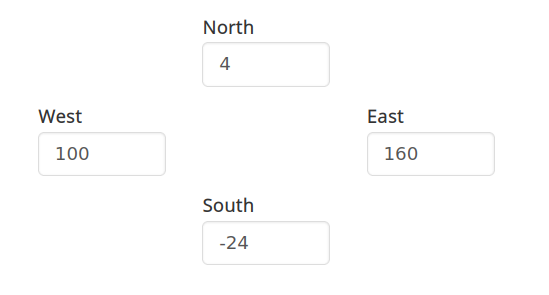



**Be careful, various users have stated how slow this download is** : https://confluence.ecmwf.int/pages/viewpage.action?pageId=143050283


In [41]:
# Load xarray
ds_wind = xr.open_dataset("../Data/Environmental_data/wind_monthly.nc")

# Make dataframe
df_wind = ds_wind.to_dataframe()
# Rename and reset longitude and latitude index
df_wind.rename(columns = {"si10":"wind_speed"}, inplace = True)
df_wind.reset_index(inplace = True)





In [42]:
gdf_wind = gpd.GeoDataFrame(df_wind, geometry=gpd.points_from_xy(df_wind.latitude, df_wind.longitude))
# Keep only month and year
gdf_wind["time"] = gdf_wind["time"].dt.strftime('%Y-%m')

In [43]:
# Drop useless columns
gdf_wind.drop(columns = ['latitude', 'longitude', 'number', 'step', 'surface',
       'valid_time'], inplace = True)
gSurvey.drop(columns = ['surveyid', 'ocean', 
       'folder_name', 'lat_start', 'lng_start', 'lat_end', 'lng_end',
       'pr_hard_coral', 'pr_algae', 'pr_soft_coral', 'pr_oth_invert',
       'pr_other'], inplace = True)

In [44]:
dates_surveys = gSurvey['surveydate'].unique()

In [45]:
def merge_(df_survey, df_env, surv_list):
    
    df = []
    for date in surv_list:
       
        df_envv = df_env[df_env["time"] == date]
        df_sur = df_survey[df_survey['surveydate'] == date]
        df_ = dp.ckdnearest(df_sur, df_envv)
        df.append(df_)

        
    return pd.concat(df)


In [46]:
frames_all = merge_(gSurvey, gdf_wind, dates_surveys)

In [47]:
Survey.drop(columns = ['surveyid', 'ocean', 'country',
       'folder_name', 'lat_start', 'lng_start', 'lat_end', 'lng_end',
        'geometry'],inplace = True)

In [48]:
df_merge_w = pd.merge(Survey, frames_all,on = ["surveydate","transectid"], how = "left")

In [49]:
dups_sur_trans = df_merge_w.pivot_table(index=['surveydate','transectid'], aggfunc='size')
print (dups_sur_trans.value_counts())
print("You have 5 surveys with 4 duplicates...remove to ease computation")

1    411
4      5
dtype: int64
You have 5 surveys with 4 duplicates...remove to ease computation


In [50]:
# Here I drop the duplicates on time and transectid, indeed I could just take the mean of them instead of 
# keeping only first value
df_mer_w = df_merge_w.drop_duplicates( subset=[ "time","transectid"], keep="first", inplace = False)

### Chlorophyll Copernicus



In [51]:
ds_chlor = xr.open_mfdataset("../Data/Environmental_data/chlorophyll/ESACCI-OC-L3S-CHLOR_A-MERGED-1D_DAILY_4km*.nc")

In [52]:
# Bounds of coordinates for Pacific
latbounds = [-24, 4]
lonbounds = [100, 160]
lats = ds_chlor.variables["lat"][:]
lons = ds_chlor.variables["lon"][:]
# latitude lower and upper index
latli = np.argmin( np.abs( lats - latbounds[0] ).values )
latui = np.argmin( np.abs( lats - latbounds[1] ).values ) 
# longitude lower and upper index
lonli = np.argmin( np.abs( lons - lonbounds[0] ).values )
lonui = np.argmin( np.abs( lons - lonbounds[1] ).values )  



In [53]:
# Subset for the given coordinates
ChlorSubset = ds_chlor.variables['chlor_a'][ : , latui:latli , lonli:lonui ] 
# Dataset with the chlor amongst the different coordinates
ds_sub_chlor = xr.Dataset(data_vars={"Chlor": ChlorSubset}, coords = {"lon":ds_chlor["lon"][lonli:lonui], "lat": ds_chlor["lat"][latui:latli], "time":ds_chlor["time"]})
df_chlor = ds_sub_chlor.to_dataframe()
df_chlor.reset_index(inplace = True)
df_chlor.head()

,lat,lon,time,Chlor
0,3.979167,100.020833,2012-01-01,NaN
1,3.979167,100.020833,2012-02-01,0.64733
2,3.979167,100.020833,2012-03-01,NaN
3,3.979167,100.020833,2012-04-01,NaN
4,3.979167,100.020833,2012-05-01,NaN


In [54]:
# remove the Nan values, so that it automatically takes the other ones 
df_chlor.dropna(axis = 0, inplace = True)

In [55]:
# Keep only month and year // Find faster function.... 
df_chlor["time"] = df_chlor["time"].dt.strftime('%Y-%m')
df_chlor.head()

,lat,lon,time,Chlor
1,3.979167,100.020833,2012-02,0.647330
26,3.979167,100.020833,2016-03,0.601783
31,3.979167,100.020833,2016-08,0.573502
36,3.979167,100.020833,2017-01,0.612619
41,3.979167,100.020833,2017-06,0.750544


In [56]:
gdf_chlor = gpd.GeoDataFrame(df_chlor, geometry=gpd.points_from_xy(df_chlor.lat, df_chlor.lon))

print(gdf_chlor.head())

         lat         lon     time     Chlor               geometry
1   3.979167  100.020833  2012-02  0.647330  POINT (3.979 100.021)
26  3.979167  100.020833  2016-03  0.601783  POINT (3.979 100.021)
31  3.979167  100.020833  2016-08  0.573502  POINT (3.979 100.021)
36  3.979167  100.020833  2017-01  0.612619  POINT (3.979 100.021)
41  3.979167  100.020833  2017-06  0.750544  POINT (3.979 100.021)


In [57]:
type(gdf_chlor["geometry"])

geopandas.geoseries.GeoSeries

In [58]:
df_merged_w_ch = merge_(df_mer_w, gdf_chlor, dates_surveys)
df_merged_w_ch.drop(columns = ['time', 'dist', 'lat', 'lon', 'time'], inplace = True)
df_merged_w_ch.head()

,transectid,surveydate,pr_hard_coral,pr_algae,pr_soft_coral,pr_oth_invert,pr_other,country,geometry,wind_speed,Chlor
0,10001,2012-09,0.1856,0.3724,0.2710,0.0010,0.1700,AUS,POINT (145.89810 -16.18902),6.939368,0.122235
1,10002,2012-09,0.1364,0.4766,0.3079,0.0020,0.0771,AUS,POINT (145.89825 -16.18930),6.939368,0.122235
2,10003,2012-09,0.2475,0.5653,0.0747,0.0207,0.0917,AUS,POINT (145.89168 -16.17577),6.939368,0.122235
3,10004,2012-09,0.1242,0.5706,0.0279,0.0023,0.2748,AUS,POINT (147.80680 -16.53665),6.992591,0.103763
4,10005,2012-09,0.0781,0.7894,0.0096,0.0029,0.1201,AUS,POINT (147.80258 -16.52922),6.992591,0.103763


In [59]:
df_merged_w_ch.to_csv("../Data/Environmental_data/merged_wind_chlor.csv", index = False)

## Start from here

Since I have already merged wind and chlorophyll, continue from here to not loose time

In [60]:
df_merged_w_ch = pd.read_csv("../Data/Environmental_data/merged_wind_chlor.csv")
df_merged_w_ch.head()


,transectid,surveydate,pr_hard_coral,pr_algae,pr_soft_coral,pr_oth_invert,pr_other,country,geometry,wind_speed,Chlor
0,10001,2012-09,0.1856,0.3724,0.2710,0.0010,0.1700,AUS,POINT (145.8981037 -16.1890227),6.939368,0.122235
1,10002,2012-09,0.1364,0.4766,0.3079,0.0020,0.0771,AUS,POINT (145.8982542 -16.1893027),6.939368,0.122235
2,10003,2012-09,0.2475,0.5653,0.0747,0.0207,0.0917,AUS,POINT (145.8916764 -16.1757678),6.939368,0.122235
3,10004,2012-09,0.1242,0.5706,0.0279,0.0023,0.2748,AUS,POINT (147.8067956 -16.5366452),6.992591,0.103763
4,10005,2012-09,0.0781,0.7894,0.0096,0.0029,0.1201,AUS,POINT (147.8025816 -16.5292156),6.992591,0.103763


In [61]:
from shapely import wkt


df_merged_w_ch['geometry'] = df_merged_w_ch['geometry'].apply(wkt.loads)

In [62]:
df_merged_w_ch['geometry']

0      POINT (145.8981037 -16.1890227)
1      POINT (145.8982542 -16.1893027)
2      POINT (145.8916764 -16.1757678)
3      POINT (147.8067956 -16.5366452)
4      POINT (147.8025816 -16.5292156)
                    ...               
411        POINT (125.177118 1.679154)
412        POINT (125.133216 1.671353)
413        POINT (125.150193 1.734514)
414        POINT (125.146803 1.836848)
415          POINT (125.13085 1.77376)
Name: geometry, Length: 416, dtype: object

## Solar radiation Copernicus


In [63]:
# Don't run again, cause already there, first time if you only have grib, then yes run
#ds_solar = xr.open_dataset("../Data/Environmental_data/solar_radiation.grib", engine = "cfgrib")
#cdf_solar = ds_solar.to_netcdf("../Data/Environmental_data/solar_rad.nc")


In [64]:
# Load xarray
ds_solar = xr.open_dataset("../Data/Environmental_data/solar_rad.nc")


# Surface net solar radiation, clear sky :: SSRC [J m**-2]
# Surface net solar radiation :: SSR [J m**-2]
# Make dataframe
df_solar = ds_solar.to_dataframe()
# Rename and reset longitude and latitude index
df_solar.rename(columns = {"ssr":"solar_rad", "ssrc":"solar_rad_clear_sky"}, inplace = True)
df_solar.reset_index(inplace = True)
df_solar.head()



,latitude,longitude,time,number,step,surface,valid_time,solar_rad,solar_rad_clear_sky
0,4.0,100.0,2011-12-31 18:00:00,0,0 days 12:00:00,0,2012-01-01 06:00:00,18220032.0,22505472.0
1,4.0,100.0,2012-01-31 18:00:00,0,0 days 12:00:00,0,2012-02-01 06:00:00,18947584.0,23912960.0
2,4.0,100.0,2012-02-29 18:00:00,0,0 days 12:00:00,0,2012-03-01 06:00:00,18467456.0,24934656.0
3,4.0,100.0,2012-03-31 18:00:00,0,0 days 12:00:00,0,2012-04-01 06:00:00,18638336.0,24757248.0
4,4.0,100.0,2012-04-30 18:00:00,0,0 days 12:00:00,0,2012-05-01 06:00:00,17528320.0,23803392.0


In [65]:
df_solar.drop(columns = ['number','time', 'step', 'surface'], inplace = True)

In [66]:

# Keep only month and year // Find faster function.... 
df_solar["valid_time"] = df_solar["valid_time"].dt.strftime('%Y-%m')
df_solar.head()

,latitude,longitude,valid_time,solar_rad,solar_rad_clear_sky
0,4.0,100.0,2012-01,18220032.0,22505472.0
1,4.0,100.0,2012-02,18947584.0,23912960.0
2,4.0,100.0,2012-03,18467456.0,24934656.0
3,4.0,100.0,2012-04,18638336.0,24757248.0
4,4.0,100.0,2012-05,17528320.0,23803392.0


In [67]:
gdf_solar = gpd.GeoDataFrame(df_solar, geometry=gpd.points_from_xy(df_solar.latitude, df_solar.longitude))
gdf_solar.rename(columns = {"valid_time" : "time"}, inplace = True)

In [69]:
df_merged_w_ch_sol = merge_(df_merged_w_ch, gdf_solar, dates_surveys)


In [70]:
df_merged_w_ch_sol.head()

,transectid,surveydate,pr_hard_coral,pr_algae,pr_soft_coral,pr_oth_invert,pr_other,country,geometry,wind_speed,Chlor,latitude,longitude,time,solar_rad,solar_rad_clear_sky,dist
0,10001,2012-09,0.1856,0.3724,0.2710,0.0010,0.1700,AUS,POINT (145.8981037 -16.1890227),6.939368,0.122235,-16.25,146.00,2012-09,20889976.0,23943344.0,0.118748
1,10002,2012-09,0.1364,0.4766,0.3079,0.0020,0.0771,AUS,POINT (145.8982542 -16.1893027),6.939368,0.122235,-16.25,146.00,2012-09,20889976.0,23943344.0,0.118475
2,10003,2012-09,0.2475,0.5653,0.0747,0.0207,0.0917,AUS,POINT (145.8916764 -16.1757678),6.939368,0.122235,-16.25,146.00,2012-09,20889976.0,23943344.0,0.131318
3,10004,2012-09,0.1242,0.5706,0.0279,0.0023,0.2748,AUS,POINT (147.8067956 -16.5366452),6.992591,0.103763,-16.50,147.75,2012-09,21851000.0,23912112.0,0.067591
4,10005,2012-09,0.0781,0.7894,0.0096,0.0029,0.1201,AUS,POINT (147.8025816 -16.5292156),6.992591,0.103763,-16.50,147.75,2012-09,21851000.0,23912112.0,0.060153


In [71]:
df_merged_w_ch_sol.drop(columns = ['time', 'dist', 'latitude', 'longitude'], inplace = True)
df_merged_w_ch_sol.head()

,transectid,surveydate,pr_hard_coral,pr_algae,pr_soft_coral,pr_oth_invert,pr_other,country,geometry,wind_speed,Chlor,solar_rad,solar_rad_clear_sky
0,10001,2012-09,0.1856,0.3724,0.2710,0.0010,0.1700,AUS,POINT (145.8981037 -16.1890227),6.939368,0.122235,20889976.0,23943344.0
1,10002,2012-09,0.1364,0.4766,0.3079,0.0020,0.0771,AUS,POINT (145.8982542 -16.1893027),6.939368,0.122235,20889976.0,23943344.0
2,10003,2012-09,0.2475,0.5653,0.0747,0.0207,0.0917,AUS,POINT (145.8916764 -16.1757678),6.939368,0.122235,20889976.0,23943344.0
3,10004,2012-09,0.1242,0.5706,0.0279,0.0023,0.2748,AUS,POINT (147.8067956 -16.5366452),6.992591,0.103763,21851000.0,23912112.0
4,10005,2012-09,0.0781,0.7894,0.0096,0.0029,0.1201,AUS,POINT (147.8025816 -16.5292156),6.992591,0.103763,21851000.0,23912112.0


## Ocean depth Copernicus // Sentinel 3

Ocean level, so negative numbers are for below water :)

In [72]:
nc_depth = nc.Dataset("../Data/Environmental_data/depth/depth.nc")

In [74]:
nc_depth.variables["elevation"]

<class 'netCDF4._netCDF4.Variable'>
int16 elevation(lat, lon)
    standard_name: height_above_reference_ellipsoid
    long_name: Elevation relative to sea level
    units: m
    sdn_parameter_urn: SDN:P01::BATHHGHT
    sdn_parameter_name: Sea floor height (above mean sea level) {bathymetric height}
    sdn_uom_urn: SDN:P06::ULAA
    sdn_uom_name: Metres
unlimited dimensions: 
current shape = (6720, 14400)
filling on, default _FillValue of -32767 used

In [1]:
# Load xarray
import xarray as xr
ds_depth = xr.open_dataset("../Data/Environmental_data/depth/depth.nc")




In [2]:


#  Sea floor height (above mean sea level) {bathymetric height} [m]
# Make dataframe
df_depth = ds_depth.to_dataframe()

In [3]:

# Rename and reset longitude and latitude index
# elevation = depth 
df_depth.reset_index(inplace = True)



In [6]:
df_depth

,lat,lon,elevation
0,-23.997917,100.002083,-5751
1,-23.997917,100.006250,-5752
2,-23.997917,100.010417,-5751
3,-23.997917,100.014583,-5749
4,-23.997917,100.018750,-5746
...,...,...,...
96767995,3.997917,159.981250,-3768
96767996,3.997917,159.985417,-3768
96767997,3.997917,159.989583,-3769
96767998,3.997917,159.993750,-3770


import geopandas as gpd
gdf_depth = gpd.GeoDataFrame(df_depth, geometry=gpd.points_from_xy(df_depth.lat, df_depth.lon))

print(gdf_depth.head())